# A/B testing in mobile games

A/B testing, also known as split testing, is a widely used method in the gaming industry to optimize various aspects of computer games. The primary motivation is to make data-driven decisions that improve the overall player experience and maximize the game's success.

The choice of metric depends on the specific objectives of the A/B test. Common metrics include player retention, daily active users (DAU), session length, churn rate, conversion rate, revenue per user (ARPU), pay-to-play ratio, user engagement, load times, bug reports, player feedback, level completion rate, and virality. These metrics help game developers assess player engagement, monetization effectiveness, performance, and overall user satisfaction.

# Scope
All analysis will be conducted on data collected for the mobile puzzle game, Cookie Cats. In this classic "connect three" puzzle, players must strategically link tiles of identical colors to clear the board and advance through levels.

# Experimental design

In the game, players face time-based barriers or can opt for in-app purchases. We're analyzing an A/B test that shifted the initial barrier from level 30 to level 40 in Cookie Cats, focusing on its impact on player retention and game rounds.

## Hypothesis
A two-way hypothesis test at a significance "alpha" level of 0.05 will be conducted.

* **Null hypothesis**: Gate position has no impact on player retention/game rounds.

* **Alternate hypothesis**: Gate position has an impact on player retention/game rounds.

## Test statistics

The following metrics are available and will be evaluated:

1. **sum_gamerounds**: the number of game rounds played by the player during the first 14 days after install.
2. **retention_1**: did the player come back and play 1 day after installing?
3. **retention 7**: did the player come back and play 7 days after installing?

# Data exploration

## Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\ab-testing-cookie-cats\\ab-testing-cookie-cats'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)
    
import config
from IPython.display import display
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-muted')
import numpy as np
import pandas as pd
from random import sample

## Import data
* Data is imported as a DataFrame.
* There are 90,1089 records.

In [2]:
ab_results = pd.read_csv(config.file_directory('raw') + 'cookie_cats.csv')
print(f"Number of records: {ab_results.shape[0]}")
ab_results.head(3)

Number of records: 90189


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


## Data types
* sum_gamerounds is a numerical variable and both retention metrics are boolean.

In [3]:
ab_results.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

## Missing values
* No missing values (NaN or None) are present.

In [4]:
ab_results.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

## A/B split

When a player installed the game, they were randomly assigned to either gate_30 or gate_40. The split is captured by the *version* feature. The data is split roughly 50/50 across these two groups.

In [5]:
display(ab_results[['version']].describe())

,version
count,90189
unique,2
top,gate_40
freq,45489


In [6]:
from custom_funcs import perc_func
version_breakdown = perc_func(ab_results, 'version')
version_breakdown

,count,perc
version,,
gate_40,45489,50.4
gate_30,44700,49.6


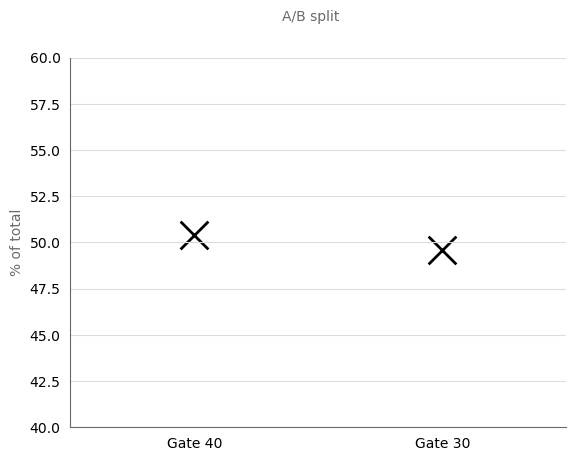

In [7]:
fig, axes = plt.subplots()
axes.scatter(version_breakdown.index,
           version_breakdown['perc'],
           marker='x',
           s=400,
           c='black',
           linewidths=2)

axes.set_xlim([-0.5, 1.5])
axes.set_ylim([round(min(version_breakdown['perc']) - 10, -1),
             round(max(version_breakdown['perc']) + 10, -1)])
axes.tick_params(bottom=False, left=False)
axes.set_xticks([0, 1], ['Gate 40', 'Gate 30'])
axes.grid(True, axis='y', color='gainsboro')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_ylabel('% of total', color='dimgray');
fig.suptitle('A/B split', fontsize=10, color='dimgray');

## Summary stats & distributions

### Number of games
* The mean and median number of game rounds is 51.9 and 16, respectively. This indicates the distribution is heavily skewed.

In [8]:
display(ab_results[['sum_gamerounds']].describe())

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


* Segmenting players by test group indicates a slight increase in the average number of games per player when the first barrier is at gate 30.
* The difference between the mean and medians (irrespective of test group) indicate a skewed distribution.

In [9]:
gamerounds_ab = pd.concat([ab_results.loc[ab_results.version == v, 'sum_gamerounds'].describe() for v in ab_results['version'].unique()],
                          axis=1,
                          keys=[v for v in ab_results['version'].unique()])
gamerounds_ab['diff'] = gamerounds_ab['gate_30'] - gamerounds_ab['gate_40']
gamerounds_ab

,gate_30,gate_40,diff
count,44700.000000,45489.000000,-789.000000
mean,52.456264,51.298776,1.157488
std,256.716423,103.294416,153.422007
min,0.000000,0.000000,0.000000
25%,5.000000,5.000000,0.000000
50%,17.000000,16.000000,1.000000
75%,50.000000,52.000000,-2.000000
max,49854.000000,2640.000000,47214.000000


* Box plots confirm skewed distributions for both test groups.
* The maximum point for gate 30 players looks like an anonomaly.

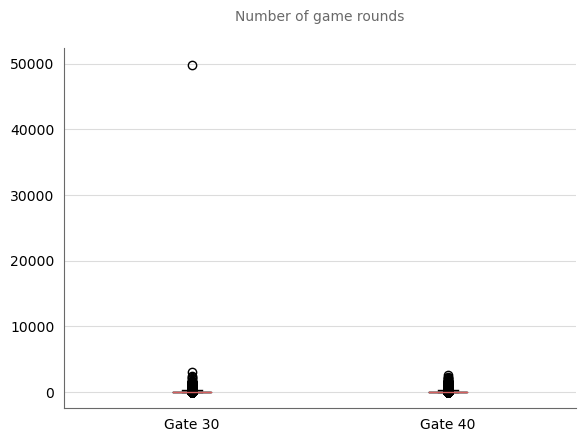

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1)
ab_results.boxplot(by='version',
                   column='sum_gamerounds',
                   ax=axes,
                   whis=[5, 95],
                   showfliers=True,
                   boxprops=dict(color='k'),
                   whiskerprops=dict(color='k'),
                   capprops=dict(color='k')
                   )
axes.set_xticks([1, 2], labels=['Gate 30', 'Gate 40'])
axes.set_xlabel('')
axes.set_title('')
fig.suptitle('Number of game rounds', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.grid(True, axis='y', which='major', color='gainsboro')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

* Histograms illustrate the broad spread for number of games per player across both test groups.

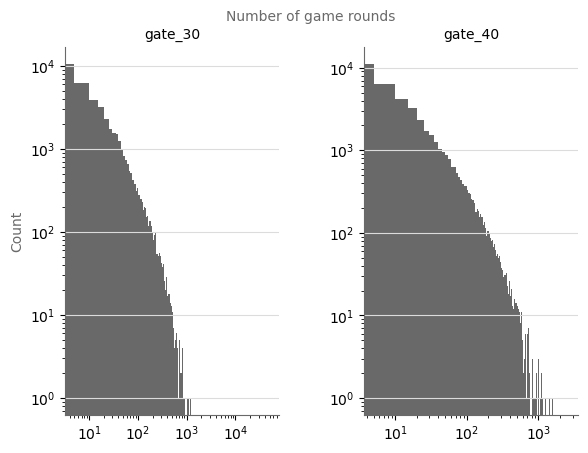

In [11]:
bin_width = 5
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.0)

for v, ax in zip(ab_results['version'].unique(), axes):
    ax.hist(ab_results.loc[ab_results.version == v, 'sum_gamerounds'],
            bins=range(0, ab_results.loc[ab_results.version == v, 'sum_gamerounds'].max() + bin_width, bin_width),
            color = 'dimgray')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, axis='y', color='gainsboro')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_title(v, fontsize=10)
axes[0].set_ylabel('Count', color='dimgray');
fig.suptitle('Number of game rounds', fontsize=10, color='dimgray');

### One day retention
* One day retention rates are 0.59% higher for gate 30 players.

In [12]:
from custom_funcs import retained_func
retent1_ab = retained_func(ab_results, 'retention_1')
retent1_ab

version,gate_30,gate_40,diff
outcome,,,
False,55.18,55.77,-0.59
True,44.82,44.23,0.59


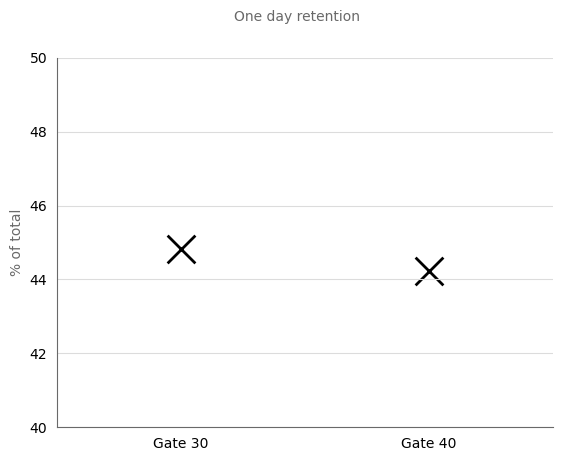

In [13]:
fig, axes = plt.subplots()
axes.scatter(retent1_ab.index,
             retent1_ab.loc[True, ['gate_30', 'gate_40']],
             marker='x',
             s=400,
             c='black',
             linewidths=2)

axes.set_xticks([0, 1], ['Gate 30', 'Gate 40'])
axes.set_ylabel('% of total', color='dimgray')
fig.suptitle('One day retention', fontsize=10, color='dimgray')
axes.set_xlim([-0.5, 1.5])
axes.set_ylim([40, 50])
axes.tick_params(bottom=False, left=False)
axes.grid(True, axis='y', color='gainsboro')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

### Seven day retention
* Seven day retention rates are 0.82% higher for gate 30 players.

In [14]:
display(ab_results[['retention_7']].describe())

,retention_7
count,90189
unique,2
top,False
freq,73408


In [15]:
retent7_ab = retained_func(ab_results, 'retention_7')
retent7_ab

version,gate_30,gate_40,diff
outcome,,,
False,80.98,81.8,-0.82
True,19.02,18.2,0.82


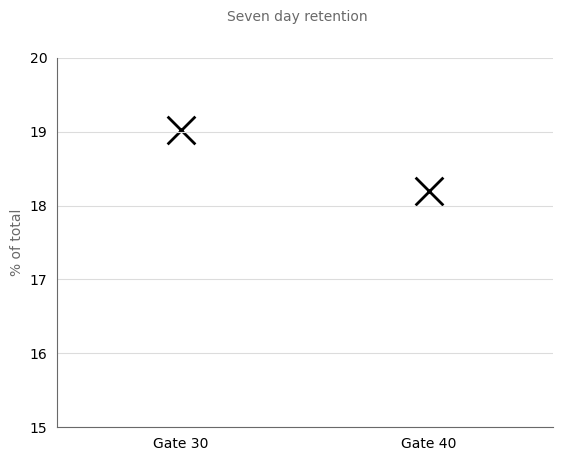

In [16]:
fig, axes = plt.subplots()
axes.scatter(retent7_ab.index,
             retent7_ab.loc[True, ['gate_30', 'gate_40']],
             marker='x',
             s=400,
             c='black',
             linewidths=2)

axes.set_xticks([0, 1], ['Gate 30', 'Gate 40'])
axes.set_ylabel('% of total', color='dimgray')
fig.suptitle('Seven day retention', fontsize=10, color='dimgray')
axes.set_xlim([-0.5, 1.5])
axes.set_ylim([15, 20])
axes.tick_params(bottom=False, left=False)
axes.grid(True, axis='y', color='gainsboro')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

## Data cleaning
* One anomalous point is removed: 49,854 plays is unrealistic in a 14 day period.

In [17]:
print(f"Maximum number of game rounds: {ab_results['sum_gamerounds'].max()}")

Maximum number of game rounds: 49854


In [18]:
ab_clean_res = ab_results.copy(deep=True)
ab_clean_res = ab_results.loc[ab_clean_res['sum_gamerounds'] != ab_clean_res['sum_gamerounds'].max()]
ab_clean_res = ab_clean_res.reset_index(drop=True)

## Permutation test

**How it works:**

1) The null hypothesis is assumed to be true
2) The sampling distribution of the test statistic is computed using a permutation test. This indicates the random variability in the test statistic
4) A p-value is calculated for the test statistic using the sampling distribution
5) A significance test is conducted. The p-value is compared to a significance threshold. If it is below the threshold, the null hypothesis is rejected (and vice versa).
   * For a single-tailed test, compare the p-value to the *alpha* significance level
   * For a two-tailed test, compare the p-value to half the *alpha* significance level
  
**P-Values:**

* The p-value represents the probability, given a chance model that embodies the null hypothesis, of a result *at least* as extreme as the observed effect. It therefore indicates whether the observed effect is a reasonable outcome of a "null" model.

**Note:** A p-value does NOT give the probability the alternate hypothesis is true. A p-value gives you the probability the observed result could be produced by a null model.

### Number of games
* The mean number of games per player is 0.04 higher when the first barrier is at gate 30.

Note: There is a slight difference in the mean value for gate_30 players due to the removal of an outlier.

In [19]:
ngames_clean_ab = pd.concat([ab_clean_res.loc[ab_clean_res.version == v, 'sum_gamerounds'].describe() for v in ab_clean_res['version'].unique()],
                          axis=1,
                          keys=[v for v in ab_clean_res['version'].unique()])
ngames_clean_ab['diff'] = ngames_clean_ab['gate_30'] - ngames_clean_ab['gate_40']
ngames_clean_ab

,gate_30,gate_40,diff
count,44699.000000,45489.000000,-790.000000
mean,51.342111,51.298776,0.043335
std,102.057598,103.294416,-1.236818
min,0.000000,0.000000,0.000000
25%,5.000000,5.000000,0.000000
50%,17.000000,16.000000,1.000000
75%,50.000000,52.000000,-2.000000
max,2961.000000,2640.000000,321.000000


* The observed difference lies close to the mean of the sampling distribution for a null model.
* Given the p-value is nearly 0.5, the null-hypothesis cannot be rejected.

p-Value: 0.473


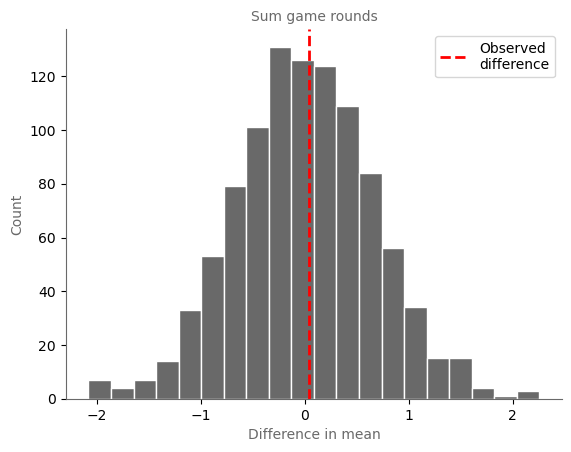

In [23]:
from custom_funcs import perm_func
ngames_perm_diffs = [perm_func(ab_clean_res['sum_gamerounds'], 44699, 45489) for _ in range(1000)]

fig, axes = plt.subplots()
axes.hist(ngames_perm_diffs, bins=20, color = 'dimgray', ec="white", lw=1)
axes.axvline(x=ngames_clean_ab.loc['mean', 'diff'], linestyle='--', color='red', lw=2, label='Observed\ndifference')
axes.set_xlabel('Difference in mean', color='dimgray')
axes.set_ylabel('Count', color='dimgray')
axes.set_title('Sum game rounds', fontsize=10, color='dimgray')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.legend();

p_val = np.mean([diff > ngames_clean_ab.loc['mean', 'diff'] for diff in ngames_perm_diffs])
print(f'p-Value: {p_val}')

### One day retention
* One day retention rates are 0.59% higher for gate 30 players.

In [22]:
retent1_clean_ab = retained_func(ab_clean_res, 'retention_1')
retent1_clean_ab

version,gate_30,gate_40,diff
outcome,,,
False,55.18,55.77,-0.59
True,44.82,44.23,0.59


* The observed difference lies above the mean of the sampling distribution for a null model.
* The p-value of 0.027 means the null-hypothesis cannot be rejected (as this is a two-tailed test with a significance level of 0.05).

p-Value: 0.027


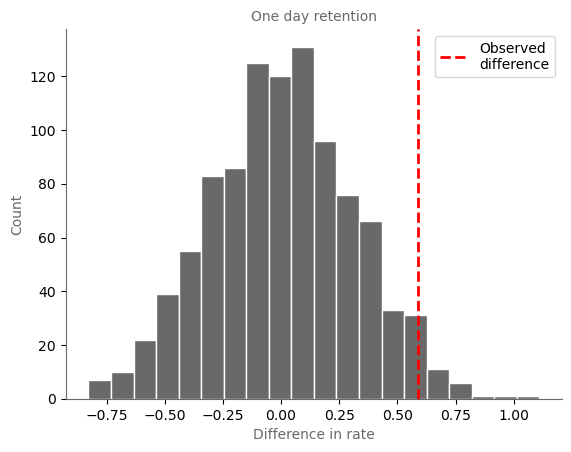

In [25]:
retent1_perm_diffs = [100 * perm_func(ab_clean_res['retention_1'], 44699, 45489) for _ in range(1000)]

fig, axes = plt.subplots()
axes.hist(retent1_perm_diffs, bins=20, color = "dimgray", ec="white", lw=1)
axes.axvline(x=retent1_clean_ab.loc[True, 'diff'], linestyle='--', color='red', lw=2, label='Observed\ndifference')
axes.set_xlabel('Difference in rate', color='dimgray')
axes.set_ylabel('Count', color='dimgray')
axes.set_title('One day retention', fontsize=10, color='dimgray')
axes.spines[['top', 'right']].set_visible(False);
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.legend();

p_val = np.mean([diff > retent1_clean_ab.loc[True, 'diff'] for diff in retent1_perm_diffs])
print(f'p-Value: {p_val}')

### Seven day retention
* Seven day retention rates are 0.82% higher for gate 30 players.

In [26]:
retent7_clean_ab = retained_func(ab_clean_res, 'retention_7')
retent7_clean_ab

version,gate_30,gate_40,diff
outcome,,,
False,80.98,81.8,-0.82
True,19.02,18.2,0.82


* The observed difference lies above the mean of the sampling distribution for a null model.
* The p-value of 0.002 means the null-hypothesis can be rejected.

p-Value: 0.002


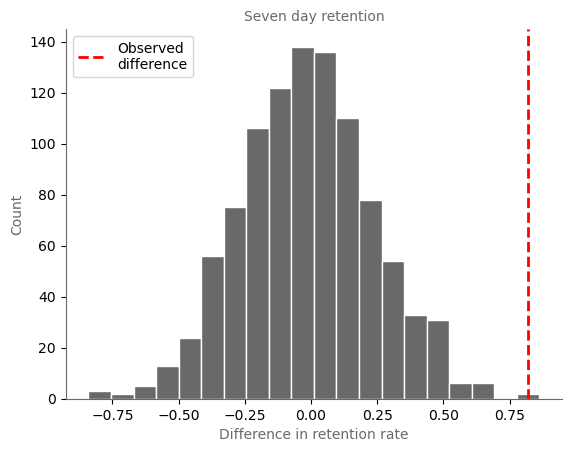

In [28]:
retent7_perm_diffs = [100 * perm_func(ab_clean_res['retention_7'], 44699, 45489) for _ in range(1000)]

fig, axes = plt.subplots()
axes.hist(retent7_perm_diffs, bins=20, color = "dimgray", ec="white", lw=1)
axes.axvline(x=retent7_clean_ab.loc[True, 'diff'], linestyle='--', color='red', lw=2, label='Observed\ndifference')
axes.set_xlabel('Difference in retention rate', color='dimgray')
axes.set_ylabel('Count', color='dimgray')
axes.set_title('Seven day retention', fontsize=10, color='dimgray')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.legend();

p_val = np.mean([diff > retent7_clean_ab.loc[True, 'diff'] for diff in retent7_perm_diffs])
print(f'p-Value: {p_val}')

## Conclusion
Neither the number of game rounds or the one day retention rate is significantly different between the two test groups. However, the seven day retention rate is significantly higher when the first barrier is set to gate 30. I would therefore reccomend the gate remains in this position.